## Aufgabe Praktikum Mobilitäts- und Datenanalyse VBZ
### Kevin Frick
### 13. Juni 2021

Import der benötigten Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipympl
import datetime

Import der Daten

In [2]:
url = 'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/'
data_20 = pd.read_csv(url + 'frequenzen_hardbruecke_2020.csv')
data_21 = pd.read_csv(url + 'frequenzen_hardbruecke_2021.csv')

Um einen ersten Überblick über die Frequenze zu erhalten, werden die täglichen Pendlerstöme in beide Richtungen über den gesamten zur verfügung stehenden Zeitraum geplottet. Da die Daten aufgrund der Wochenenden eine stark periodisch sind, wir in einem zusätzlichen Tab der 7-Tage-Schnitt geplottet.

In [3]:
# Zusammenhängen der DataFrames und Konvertierung der Daten ins Timestamp Format
data = pd.concat([data_20, data_21], axis = 'rows')
data['Date_Time'] = pd.to_datetime(data.Timestamp)
data = data.drop(columns = ['Timestamp'])

# Erstellen der Tagessummen und des 7-Tage-Schnitts
day = data.resample('D', on='Date_Time').sum()
day_7dmean = day.rolling('7d').mean()

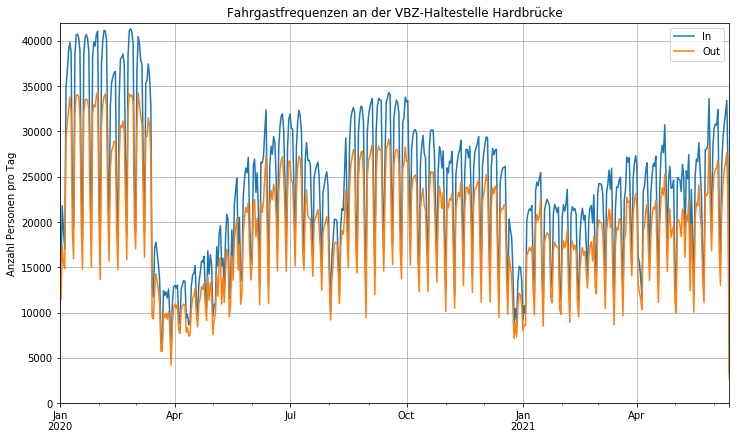

In [4]:
# Plot der Daten
fig, axes = plt.subplots()
day.plot.line(ax = axes, figsize = (12,7), grid = 'on',
              title = 'Fahrgastfrequenzen an der VBZ-Haltestelle Hardbrücke' )
axes.set_xlabel('')
axes.set_ylabel('Anzahl Personen pro Tag')
axes.set_ylim([0, 42000])
plt.show(fig)

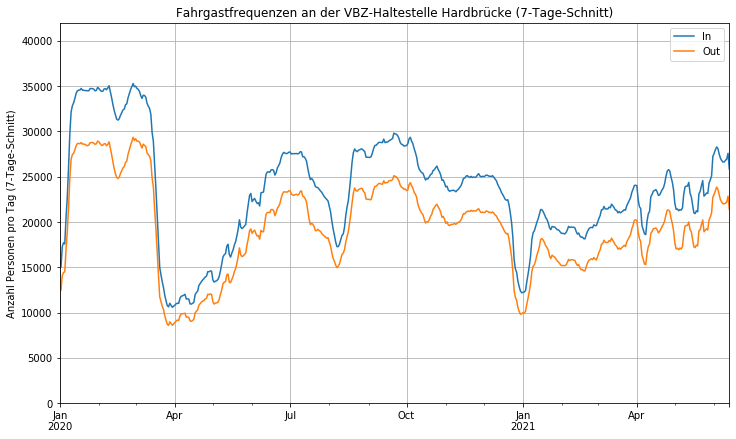

In [5]:
# Plot der Daten
fig, axes = plt.subplots()
day_7dmean.plot.line(ax = axes, figsize = (12,7), grid = 'on',
                     title = 'Fahrgastfrequenzen an der VBZ-Haltestelle Hardbrücke (7-Tage-Schnitt)')

axes.set_xlabel('')
axes.set_ylabel('Anzahl Personen pro Tag (7-Tage-Schnitt)')
axes.set_ylim([0, 42000])
plt.show(fig)

Die Massnahmen des Bundes zur Eindämmung der Covid-19 Pandemie im Frühling 2020 haben sich besonders stark auf die Frequenzen an der VBZ-Haltestelle Hardbrücke ausgewirkt. Die Sommerferien und die Festtage führen ebenfalls zu einem starken Rückgang der Frequenzen. Ein zusätzlicher Grund für die tieferen Zahlen im August 2020 ist der Ausfall des Sensors am östlichen Zugang zur S-Bahn Station. Auffällig ist auch, dass beim Zugang höhere Frequenzen gemessen werden als in die andere Richtung. Da es sich bei den Perrons jedoch um ein geschlossenes System handelt, sind diese Differenzen vermutlich auf Messfehler zurückzuführen.

Um den Pendlerfluss an einem Werktag analysieren zu können, werden die Daten folgen so aufbereitet, dass für jeden Sensor die durchschnittlichen Pendlerflüsse für jede Stunde an einem Werktag visualisiert werden können. Dazu werden die Daten von den letzten 12 Monaten (Juni 2020 - Mai 2021) verwendet.

In [6]:
# Filtern nach Zeitraum (Juni 2020 - Mai 2021)
last_12m = data.loc[lambda x: (x.Date_Time >= '2020-06') & (x.Date_Time < '2021-06')]\
               .reset_index(drop = True)

# Filtern nach Wochentagen (Montag - Freitag)
last_12m['weekday'] = last_12m.Date_Time.dt.weekday

weekdays = last_12m.loc[lambda x: x.weekday < 5]\
                   .reset_index(drop = True)\
                   .drop(columns = ['weekday'])

# Gruppieren und aggregieren nach Sensoren und Stunden
wd_hour = weekdays.groupby('Name')\
                  .resample('H', on = 'Date_Time').sum()\
                  .reset_index(drop = False)
wd_hour['time'] = wd_hour.Date_Time.dt.time
hourly = wd_hour.groupby(['Name', 'time']).agg({'In': 'mean', 'Out': 'mean'})

In [7]:
# Definieren der Plotfunktion
def plot_barplot(df, out, sensor_name):
    with out:
        fig, axes = plt.subplots()
        df.plot.bar(ax = axes, figsize = (12,7), grid = 'on',
                      title = 'Durchschnittliche Fahrgastfrequenzen an einem Werktag (Juni 2020 - Mai 2021) ' + sensor_name )
        axes.set_xlabel('Beginn der berücksichtigten Stunde')
        axes.set_ylabel('Durchschnittliche Anzahl Person pro Stunde an einem Werktag')
        axes.set_ylim([0, 550])
        plt.show(fig)

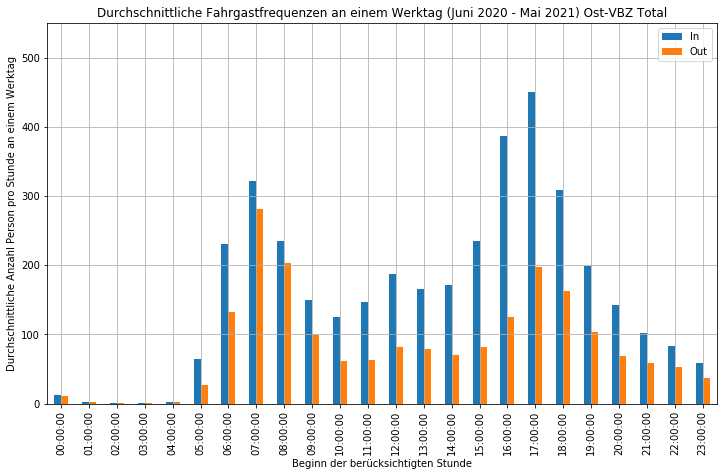

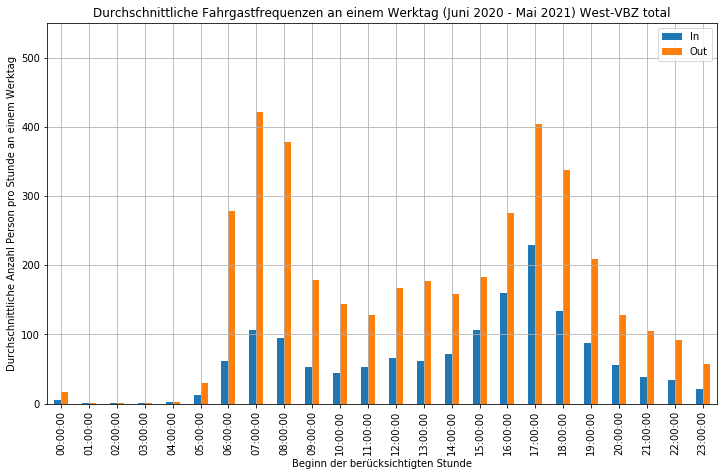

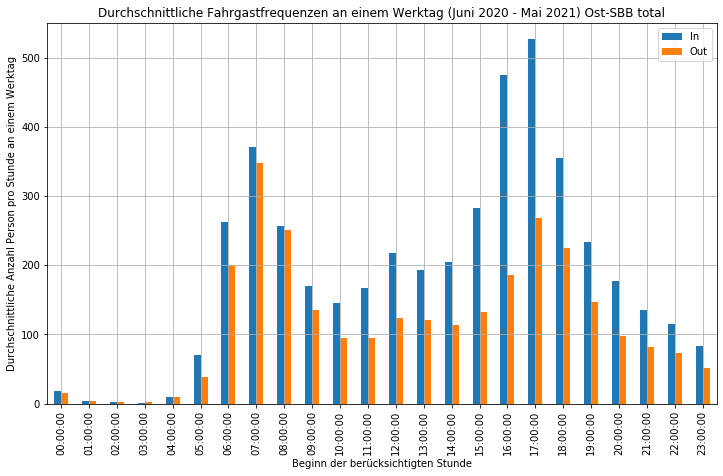

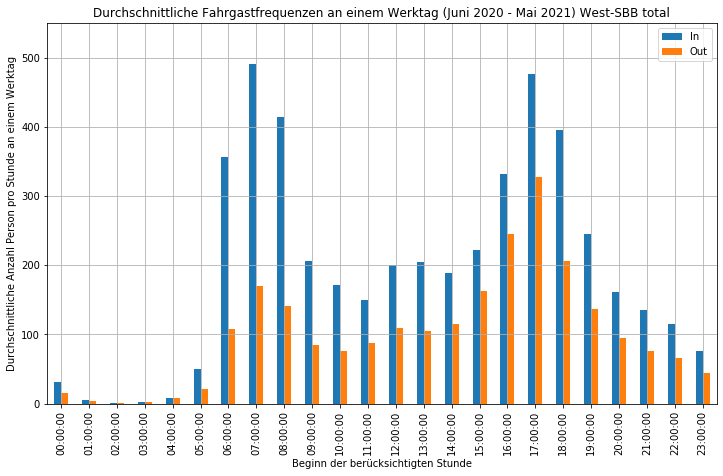

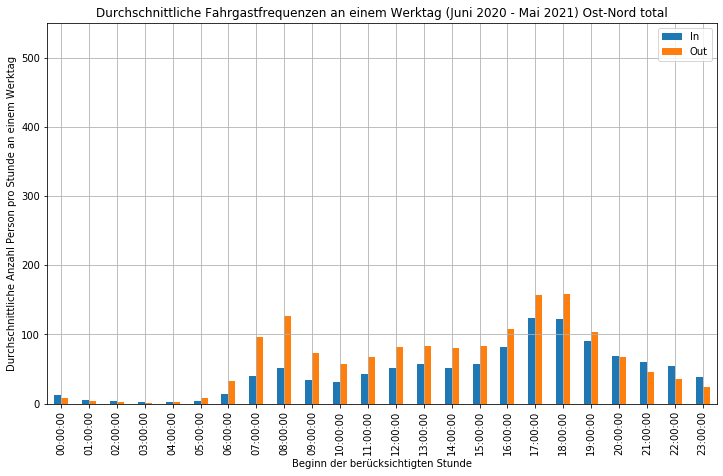

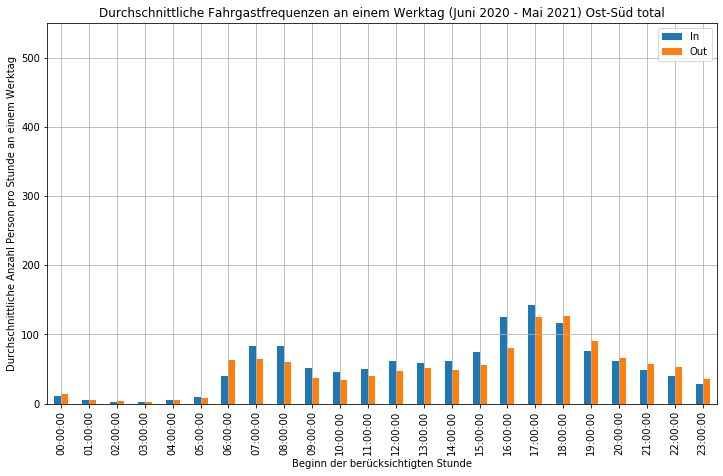

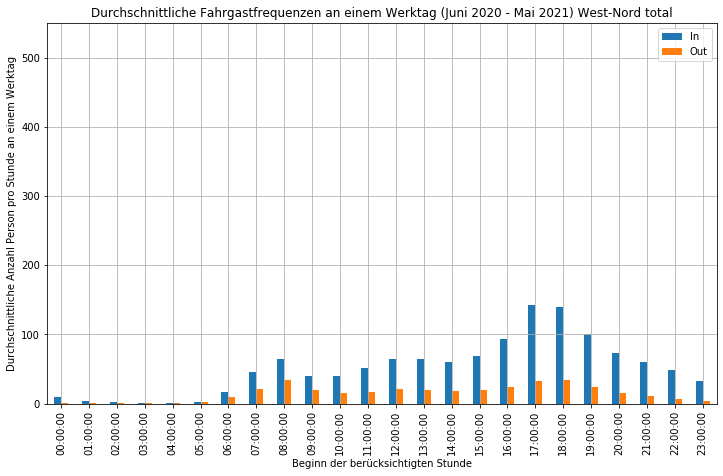

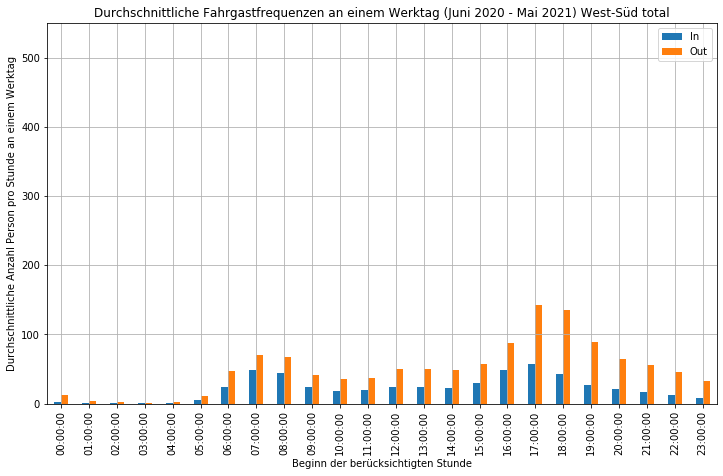

In [8]:
# Erstellen der Plots
sensors = ['Ost-VBZ Total', 'West-VBZ total', 'Ost-SBB total', 'West-SBB total',
           'Ost-Nord total', 'Ost-Süd total', 'West-Nord total', 'West-Süd total']

# Definieren der Plotfunktion
def plot_barplot_raw(df, sensor_name):
    fig, axes = plt.subplots()
    df.plot.bar(ax = axes, figsize = (12,7), grid = 'on',
                  title = 'Durchschnittliche Fahrgastfrequenzen an einem Werktag (Juni 2020 - Mai 2021) ' + sensor_name )
    axes.set_xlabel('Beginn der berücksichtigten Stunde')
    axes.set_ylabel('Durchschnittliche Anzahl Person pro Stunde an einem Werktag')
    axes.set_ylim([0, 550])
    plt.show(fig)
    
for i in range(len(sensors)):
    plot_barplot_raw(hourly.loc[sensors[i]], sensors[i])

Die Frequenzen der Zugänge von der Strasse an die Haltestelle sind verhältnissmässig tief. Daraus kann geschlossen werden, dass die VBZ-Haltestelle Hardbrücke primär zum Umsteigen auf die S-Bahn (oder umgekehrt) genutzt wird. Ausserdem kann aus den Visualisierungen abgelesen werden, dass mehr Personen das Tram in Richtung Escher-Wyss-Platz nutzen als in die entgegengesetzte Richtung. Insgesamt ist die Abendspitze stärker frequentiert als die Morgnspitze.